# <font color = 'brown'>Politics Project (공정배 민유진 유영재 장은경)<font>

## <font color = 'blue'>주제 : 네이버 상위권 뉴스와 정부 지지율 관계성 파악<font>
> - 정치 / 경제 / 사회 3가지 카테고리를 이용
- 기사의 헤드라인의 키워드 빈도수를 이용
- 기사 랭크 top5 와 top30 나눠서 분석
- 문재인 정부의 1년 간의 지지율 데이터 추출 및 관계도 파악 (2017년 11월 1일 ~ 2018년 11월 15일)

## <font color = 'red'>기사 크롤링 함수<font>

In [1]:
from bs4 import BeautifulSoup 
from urllib.request import urlopen

import numpy as np
import pandas as pd


# 크롤링 하는 함수
def crawling_news(startDay, endDay, numOfNews):
    Day = []
    polTitle = []
    ecoTitle = []
    socTitle = []
    totalTitle = []
    
    # 시작과 끝 날짜 입력
    startDay, endDay = str(startDay), str(endDay)
    
    # 날짜목록 만들기
    dayList = pd.date_range(start = startDay, end = endDay)
    dayList = dayList.strftime('%Y%m%d').tolist()
    
    # 카테고리
    categorys = ['100', '101', '102']  # 100 : 정치 / 101 : 경제 / 102 : 사회
    
    # 크롤링
    url = 'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId={}&date='
    
    for category in categorys:
        urlBasic = url.format(category)
    
        for day in dayList:
            # html 수집
            urlDay = urlBasic + day
            html = urlopen(urlDay)
            soup = BeautifulSoup(html, "lxml")
        
            # 기사 헤드라인 수집
            newsTitle = soup.find_all('div', 'ranking_headline')
        
            for n in range(numOfNews):
                # 정치 기사만 수집
                if category == '100':
                    Day.append(day)
                    polTitle.append(newsTitle[n].get_text().strip())
                
                # 경제 기사만 수집
                if category == '101':
                    ecoTitle.append(newsTitle[n].get_text().strip())
                
                # 사회 기사만 수집
                if category == '102':
                    socTitle.append(newsTitle[n].get_text().strip())
    
    # 정치/경제/사회 헤드라인 합치기 과정
    for n in range(len(polTitle)):
        tmpTitle =  polTitle[n] + ' ' + ecoTitle[n] + ' ' + socTitle[n]
        totalTitle.append(tmpTitle)
    
    # 데이터 프레임 생성
    data = {'날짜' : Day, '정치' : polTitle, '경제' : ecoTitle, '사회' : socTitle, '종합' : totalTitle}
    news = pd.DataFrame(data)
    
    return news

## <font color = 'red'>대통령 지지율 크롤링 함수<font>
> - 취임부터 2018년 11월까지 데이터 추출
- 출처: 위키피디아, 한국갤럽
- https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%A7%80%EC%A7%80%EC%9C%A8

In [2]:
import re

# 대통령 지지율 크롤링 함수
def support():
    # 위키피디아 html 가져오기
    url  = 'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%A7%80%EC%A7%80%EC%9C%A8#cite_note-%EC%B6%94%EC%84%9D-8'
    html = urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    div_title = soup.find_all('tbody')[6].find_all('td')
    
    # 이중 리스트 구조를 이용해 각 주의 지지율 리스트 만들기
    weekSupportList = []
    weekSupport = []
    for n in range(len(div_title)):
        element = div_title[n].get_text().strip()
        if '미조사' in element:
            weekSupport.append('NA')
            continue
        if '월' in element:
            weekSupport = []
            weekSupportList.append(weekSupport)
        weekSupport.append(element)
    
    # 주 정보에서 년도 월 추출
    YEAR=[]
    MONTH=[]
    for element in weekSupportList:
        pattern = re.compile('(\d{4}\w)')
        year = int(pattern.search(element[0]).group()[:-1])
        pattern = re.compile('(\s\d{1,2}\w)')
        month = str(int(pattern.search(element[0]).group()[:-1])).zfill(2)
    
        YEAR.append(year)
        MONTH.append(month)
    
    # 년도와 월 합치기
    DATE=[]
    for i in range(len(MONTH)):
        date= '{year}{month}'.format(year=YEAR[i], month=MONTH[i])
        DATE.append(int(date))
        
    uniqueDate = set(DATE)
    uniqueDate = list(uniqueDate)
    
    # 지지율 추출
    PERCENT=[]
    for i in range(len(weekSupportList)):
        percent = weekSupportList[i][1]
        PERCENT.append(percent)
    
    print(len(DATE))
    print(len(PERCENT))
    
    # 초기 데이터 프레임 생성
    data = pd.DataFrame({"날짜": DATE,"지지율": PERCENT})
    data = data.set_index("날짜")
    
    # 월 지지율을 마지막 주의 지지율로 대체
    date = []
    support = []
    for i in range(len(uniqueDate)):
        if data.loc[uniqueDate[i]].iloc[-1][0] == 'NA':
            support.append(data.loc[uniqueDate[i]].iloc[-2][0])
        else:
            support.append(data.loc[uniqueDate[i]].iloc[-1][0])
        date.append(uniqueDate[i])
        
    # 최종 데이터 프레임 생성
    result = pd.DataFrame({'날짜' : date, '지지율' : support})
    result.sort_values(by = '날짜', inplace=True)
    result = result.iloc[5:]  # 1년간의 데이터만 추출
    result.set_index("날짜", inplace=True)
    
    return result

## <font color = 'red'>키워드 추출하는 함수<font>
> - 빈도수가 높은 순으로 정렬
- 원하는 카테고리를 정해서 추출

In [3]:
from konlpy.tag import Okt
from collections import Counter
import re

# 상위 키워드 뽑아내는 함수
def extract_keyword(yearMonth, numOfWord, category, data,filterWord=[]):
    
    noFilterNoun = []       # 정제되지 않은 단어를 담을 공간
    filterNoun = []         # 정제된 단어를 담을 공간
    wordList = []           # 정제하고 빈도까지 체크한 단어를 담을 공간
    wordFreq = []           # 정제한 단어의 빈도 수를 담을 공간
    
    # 년도와 월 필터
    day = re.compile('{}\d+'.format(str(yearMonth)))
    
    # 지정한 년, 월에 해당하는 단어만 추출하는 과정
    okt = Okt()
    for n in range(len(data['종합'])):
        if day.search(str(data['날짜'][n])):
            noFilterNoun.extend(okt.nouns(data['{}'.format(category)][n]))
    
    # 단어 정제 과정
    for word in noFilterNoun:
        if len(word) == 1: continue
        elif word in filterWord: continue
        filterNoun.append(word)
    
    # 빈도수가 높은 단어 추출
    cnt = Counter(filterNoun)
    for word, freq in cnt.most_common(numOfWord):
        wordList.append(word)
        wordFreq.append(freq)
    
    # 데이터 프레임 형성
    colName = [(yearMonth, '단어'), (yearMonth, '빈도')]
    
    df = pd.DataFrame({'단어' :wordList, '빈도':wordFreq})
    df.rename(index=str, columns={'단어' : colName[0], '빈도' : colName[1]}, inplace=True)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=['날짜', '종류'])
    
    return df

## <font color = 'red'>단어 필터<font>
> 버전을 2가지로 형성 (많은 키워드 수집을 위한 약한 필터 / 임팩트 있는 키워드 수집을 위한 강한 필터)
- 정치
- 경제
- 사회
- 종합 (정치 경제 사회 모두를 한꺼번에 고려한 것)

### 정치 필터

In [42]:
# 약한 필터
polFilterWordsWeak = ['종합', '단독',  '박근', '기식', '정은', '이명', '경수', '영철', '이방', '여정','송영',
                        '주원','영남','이재','안희','희정','오늘','노회','폼페이','심재','관진', '압수', '수색',
                        '바른', '정당', '바른', '정당', '관계', '종학', '당원', '철수','처리', '현송', '대화',
                        '현진',  '실험장', '계리','주한',  '부선', '이유',  '시간', '재인', '전원', '사람', 
                        '뉴스', '개월','공중','이용','1명','지방', '20년', '계속', '출구', '세월', '특별', '9월',
                        '기무', '카드','학규', '오후', '20년', '공중', '급유기', '이용', '동연', '운전', '용석',
                        '팩트', '체크', '내년', '15년',  '연재','그린', '올해']

# 강한 필터
polFilterWordsStr = ['종합', '단독',  '박근', '기식', '정은', '이명', '경수', '영철', '이방', '여정','송영',
                       '주원','예산','영남','이재','안희','희정','오늘','노회','폼페이','심재','대통령','국민',
                       '관진', '압수', '수색','바른', '정당','한국', '바른', '정당', '정부', '관계','종학', 
                       '정부', '당원', '철수','처리', '현송', '대화', '서울', '현진', '의원', '실험장', '계리',
                       '문대통령','주한', '대표', '부선', '이유', '장관', '시간', '재인', '문재인', '전원', 
                       '은혜', '사람', '뉴스', '개월','공중','이용', '1명','지방', '20년', '계속', '출구', 
                       '세월', '특별', '9월', '기무', '카드', '시대', '학규', '오후', '20년', '공중', '급유기',
                       '이용', '동연', '운전', '용석', '확인', '팩트', '체크', '내년', '15년', '내년', '아동',
                       '연재','그린', '올해']

### 경제 필터

In [45]:
# 약한 필터
ecoFilterWordsWeak = ['종합', '단독', '10', '11', '박근', '기식', '정은', '이명', '경수', '영철', '이방', '여정',
              '송영','전자','게뜨','20','군제','30','패딩','코스','비트코','가상','화폐','상화','상화폐',
              '동연','조현','대한','증권','바이오','주택자','13','부세']

# 강한 필터
ecoFilterWordsStr = ['파리','게뜨','군제','코스','패딩','가상','화폐','비트코','상화','상화폐','거래'
                       '동연','군산','공장','금호','조현','대한','양호','바이오','항공','압수','수색',
                       '부세','종합', '송영', '동연', '단독', '전자', '조현', '10', '게뜨', '대한', '11', '20', 
                       '증권', '박근', '군제', '바이오', '기식', '30', '주택자', '정은', '패딩', '13', '이명', 
                       '코스', '부세', '경수', '비트코', '영철', '가상', '이방', '화폐', '여정', '상화', 
                       '상화폐', '한국', '대통령', '파리', '삼성전자', '정부', '올해','암호', 
                       '타이어', '금호', '양호', '회장', '직스', '52', '개월', '리포트', '9월', '이후', '이유', 
                       '100', '철강관세','관세폭탄','금리인상','군산공장','논란' ]

### 사회 필터

In [44]:
# 약한 필터
socFilterWordsWeak = []

# 강한 필터
socFilterWordsStr = ['르스','메르']

### 종합 필터

In [46]:
# 약한 필터
totalFilterWordsWeak = polFilterWordsWeak + ecoFilterWordsWeak + socFilterWordsWeak

# 강한 필터
totalFilterWordsStr = polFilterWordsStr + ecoFilterWordsStr + socFilterWordsStr

## <font color = 'red'>main 함수<font>
> - extract_keyword 내부에서 호출 함수 이용
- 키워드를 얻기 위한 자잘한 과정들을 내부적으로 모듈화

In [8]:
def main(startDay, endDay, numOfWord, category, data, filterWord=[]):
    
    # 날짜 목록 만들기
    yearMonthList = pd.period_range(start=startDay, end=endDay, freq='M')
    yearMonthList = yearMonthList.strftime('%Y%m').tolist()
    
    # 정제한 키워드 단어를 담을 데이터 프레임
    resultWords = pd.DataFrame()
    
    # 키워드 뽑아내기 (기존에 만든 extract_keyword 함수 호출)
    for yearMonth in yearMonthList:
        tmpDf = extract_keyword(yearMonth, numOfWord, category, data, filterWord)
        resultWords = pd.concat([resultWords, tmpDf], axis=1)
    
    return resultWords

## <font color = 'red'>전체적인 동작<font>
> - 기사 크롤링 함수 동작
- 정부 지지율 크롤링 함수 동작
- main 함수로 키워드 추출
- 데이터 시각화

### 기사 크롤링 동작

In [9]:
#newsTop30 = crawling_news(20171101, 20181115, 30)
#newsTop30

In [10]:
# 기사 TOP 30 파일 저장

#newsTop30.to_csv('data/naver_news_top30.csv', sep=',', encoding='UTF-8')

#newsTop30.to_excel('data/naver_news_top30.xlsx')

In [11]:
# 기사 Top 5 크롤링
#newsTop5 = crawling_news(20171101, 20181115, 5)
#newsTop5

In [12]:
# 기사 Top 5 저장
#newsTop5.to_csv('data/naver_news_top5.csv', sep=',', encoding='UTF-8')
#newsTop5.to_excel('data/naver_news_top5.xlsx')


In [9]:
# 기사 Top 5 불러오기
newsTop5 = pd.read_csv('data/naver_news_top5.csv', encoding='UTF-8')
newsTop5.drop('Unnamed: 0', axis=1, inplace=True)
newsTop5.head()

,날짜,정치,경제,사회,종합
0,20171101,"[종합]차은택, 징역 5년 구형에 울음…""이미 사회적 사형""",30대 빚내서 집 사느라 허덕인다,교수→ 전공의→ 의대생… 의료계 ‘갑질 카스트’,"[종합]차은택, 징역 5년 구형에 울음…""이미 사회적 사형"" 30대 빚내서 집 사느..."
1,20171101,"文대통령, '국민' 70번·'경제' 39번 강조…시정연설 키워드","[종합]검찰, 롯데 신격호에 징역 10년·벌금 3000억 구형","검찰 ""이영학 변태성욕장애…성적 대상 필요해 범행""","文대통령, '국민' 70번·'경제' 39번 강조…시정연설 키워드 [종합]검찰, 롯데..."
2,20171101,"文대통령 '국가역할론' 강조…IMF로 왜곡된 사회, 국가가 정상화(…","규제의 칼날에도 집값 상승, 왜?…'버티기'에 양극화 심화","""악마도 살려야하나""…불붙은 '사형 부활' 여론","文대통령 '국가역할론' 강조…IMF로 왜곡된 사회, 국가가 정상화(… 규제의 칼날에..."
3,20171101,"[종합]朴청와대, 국정원 상납금으로 4.13총선 여론조사",429조 예산전쟁 개막… 공무원 증원 최대 쟁점,"""유치원 입학 전쟁""…'처음학교로' 학부모 불편 덜어줄까","[종합]朴청와대, 국정원 상납금으로 4.13총선 여론조사 429조 예산전쟁 개막… ..."
4,20171101,"文대통령, 한반도 평화실현 5원칙 제시…'운전자론' 재확인","검찰, '채용비리' 이병삼 前금감원 부원장보 구속영장 청구(종합)","방문진 여권측 이사진, MBC 김장겸 사장 해임안 제출","文대통령, 한반도 평화실현 5원칙 제시…'운전자론' 재확인 검찰, '채용비리' 이병..."


## 데이터 시각화
> - 정부 지지율 그래프
- 정치 경제 월 단위 워드 클라우드
- 카테고리 총합 월 단위 워드 클라우드

### 정부 지지율 크롤링 동작

In [14]:
#governmentSupport = support()
#governmentSupport.head()

In [15]:
# 정부 지지율 파일 저장

#governmentSupport.to_csv('data/governmentSupport.csv')
#governmentSupport.to_excel('data/governmentSupport.xlsx')

In [82]:
# 정부 지지율 파일 읽어오기

governmentSupport = pd.read_csv('data/governmentSupport.csv', encoding='UTF-8')
governmentSupport.head()

,날짜,지지율
0,201710,73.0%
1,201711,75.0%
2,201712,68.5%
3,201801,64.0%
4,201802,64.0%


### main 함수 동작 > 키워드 추출

In [11]:
totalWords5 = main(20171101, 20181101, 30, '종합', newsTop5, totalFilterWordsStr)

In [12]:
PoliticsWords5 = main(20171101, 20181101, 30, '정치', newsTop5, totalFilterWordsStr)

In [13]:
EconomyWords5 = main(20171101, 20181101, 30, '경제', newsTop5, totalFilterWordsStr)

In [20]:
# #키워드 파일 저장

# totalWords5.to_csv('data/keyword_total_top5_strong_ver1.csv', sep=',', encoding='UTF-8')
# totalWords5.to_excel('data/keyword_total_top5_strong_ver1.xlsx', encoding='UTF-8')

In [21]:
# #키워드 파일 읽어오기

# totalWords5 = pd.read_csv('data/keyword_total_top5_strong_ver1.csv', header=[0,1], encoding='UTF-8')
# totalWords5.drop('Unnamed: 0', axis=1, inplace=True)
# totalWords5.head()

## <font color = 'red'>데이터 시각화<font>
> - 정부 지지율 월 단위 그래프
- 정치/경제 top30 월 단위 워드클라우드
- 종합 키워드 top5 월 단위 워드클라우드

### 정부 지지율 그래프

In [15]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline

# 경고 메시지 안 뜨게 하기 위해서
import warnings
warnings.filterwarnings("ignore")

In [83]:
# 날짜와 지지율을 알맞게 형변환
for i in range(len(governmentSupport['날짜'])):
    # 날짜
    governmentSupport['날짜'] = governmentSupport['날짜'].astype('str')
    governmentSupport['날짜'][i] = governmentSupport['날짜'][i][:4] + '.' + governmentSupport['날짜'][i][4:]
    
    # 지지율
    governmentSupport['지지율'][i] = float(governmentSupport['지지율'][i].replace('%',''))

<function matplotlib.pyplot.show(*args, **kw)>

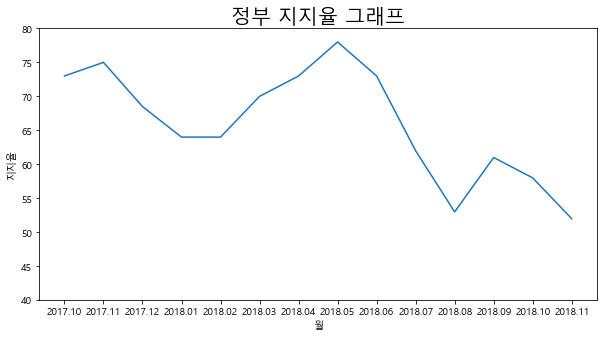

In [87]:
plt.figure(figsize=(10,5))
plt.plot(governmentSupport['날짜'], governmentSupport['지지율'])
plt.ylim(40, 80)
plt.title('정부 지지율 그래프', fontsize=20)
plt.xlabel('월')       
plt.ylabel('지지율') 
plt.show

### 워드클라우드

In [25]:
from IPython.display import Image

import random
import pytagcloud      # requires Korean font support

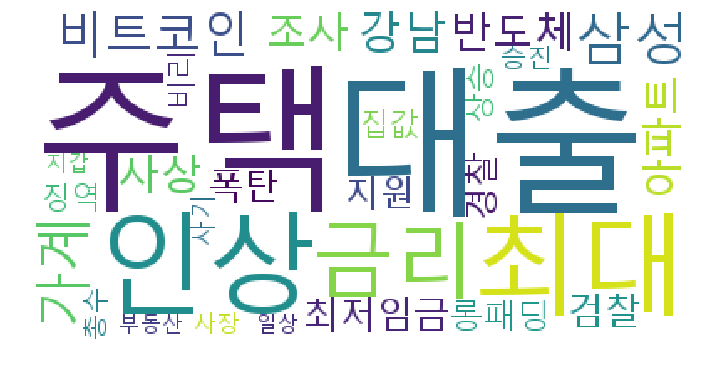

In [97]:
# 2017년 11월 경제부분 워드클라우드

from wordcloud import WordCloud

dic = {}
for i in range(len(EconomyWords5['201711']['단어'])):
    # 1.2 제곱 해서 가중치
    dic[EconomyWords5["201711"]["단어"][i]] = int(EconomyWords5['201711']['빈도'][i] ** 1.4) 
    
wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                      background_color='white'
                     ,relative_scaling =0.3).generate_from_frequencies(dic)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
save_img = 'test_1.png'
plt.savefig(save_img)

In [90]:
len(EconomyWords5.columns)

26

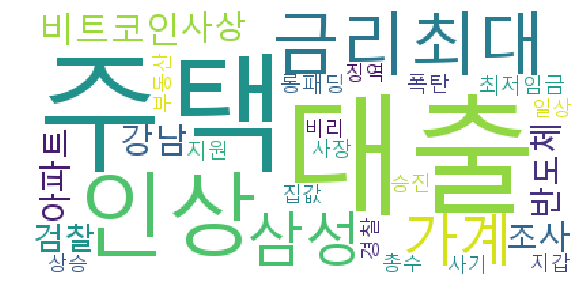

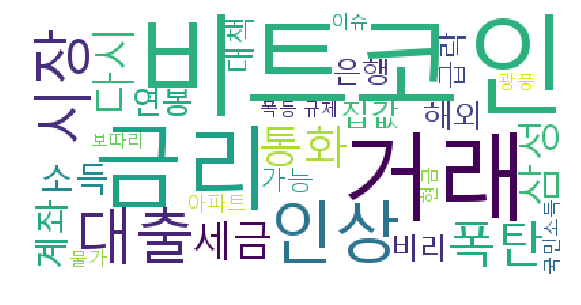

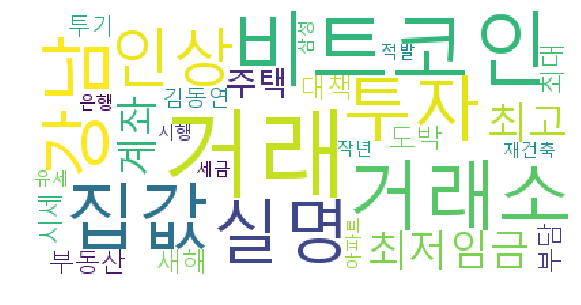

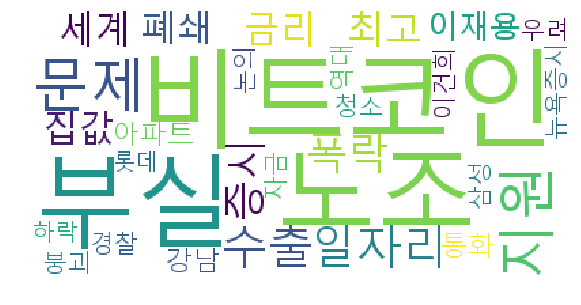

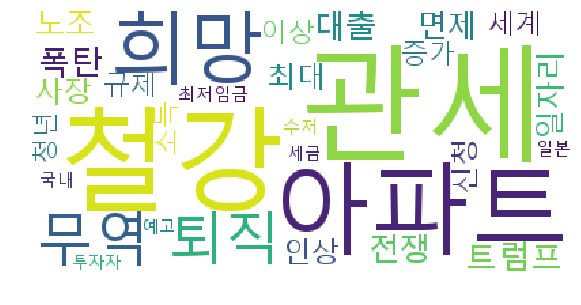

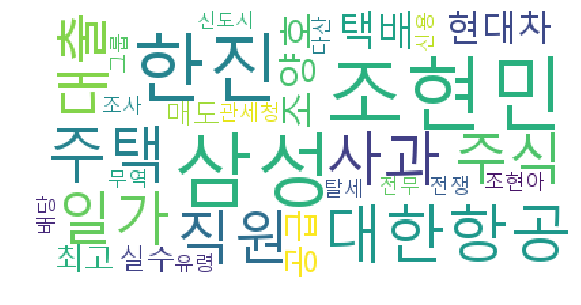

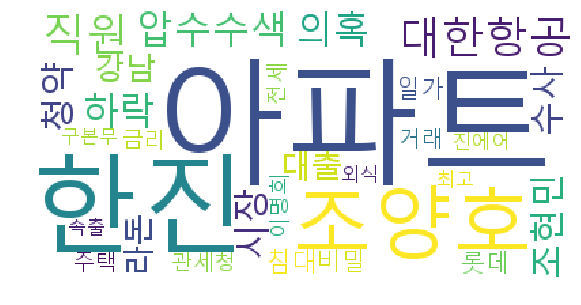

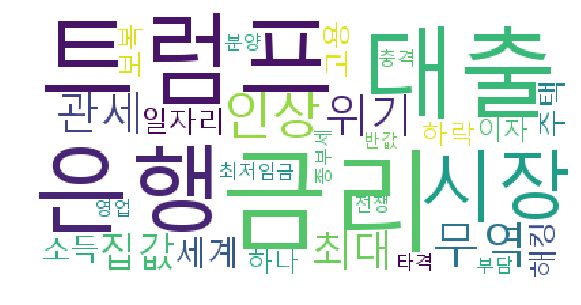

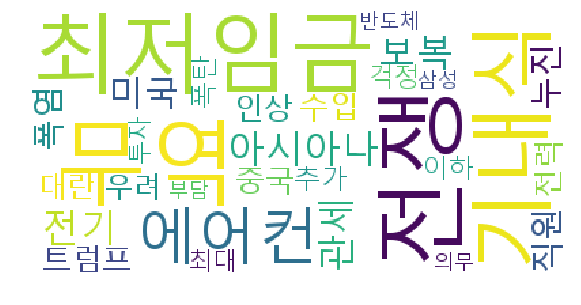

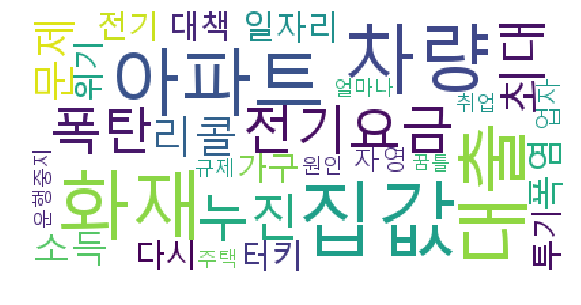

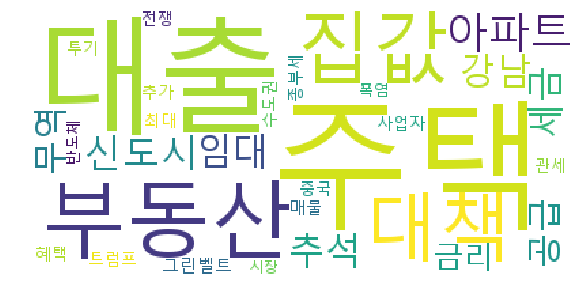

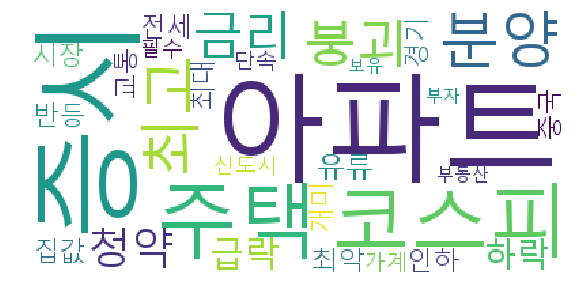

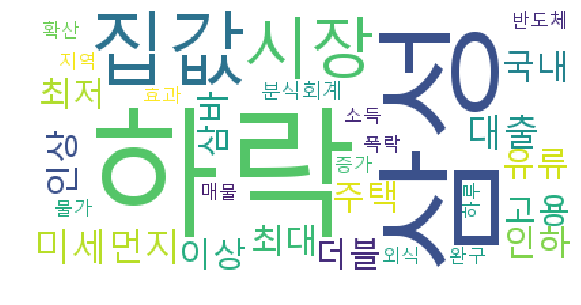

In [31]:
# 경제부분 1711~1811 <13개월> 워드클라우드

from wordcloud import WordCloud

dic = {}
for j in range(len(EconomyWords5.T.iloc[:])): # 여기서 len은 26! 1711~1811의 13개월에 <단어, 빈도> 두 열이 있어서 13 X 2는 26개!
    if j % 2 == 0:# 각 월의 <단어> 열을 추출
        for i in range(len(EconomyWords5.iloc[:])): # 여기서 len은 30!!, 단어빈도수 top 30개!!
            
            dic[EconomyWords5.T.iloc[j][i]] = int(EconomyWords5.T.iloc[j+1][i] ** 1.2) # [j+1] 은 <빈도>!!
                                                                                    # 1.2 제곱은 비중을 높여서 글자 크게 보이게끔!
            
            
        wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                              background_color='white', relative_scaling =0.2).generate_from_frequencies(dic)


        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud)
        plt.axis('off')
        save_img = 'Economy_{}.png'.format(j)
        plt.savefig(save_img)  
        
        dic = {}
        
    else:
        pass


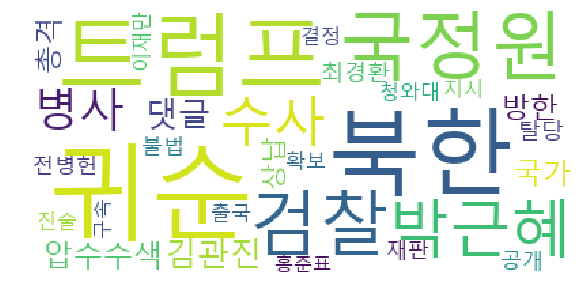

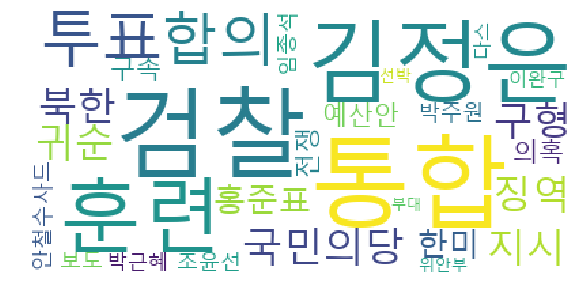

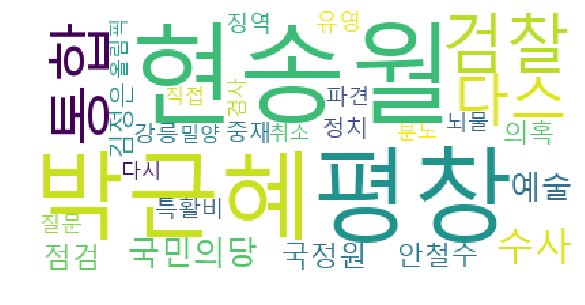

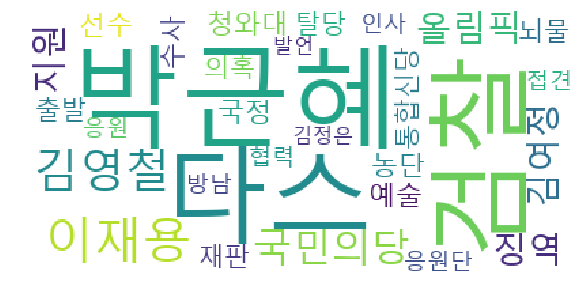

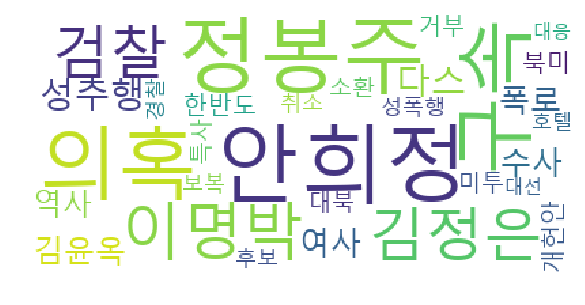

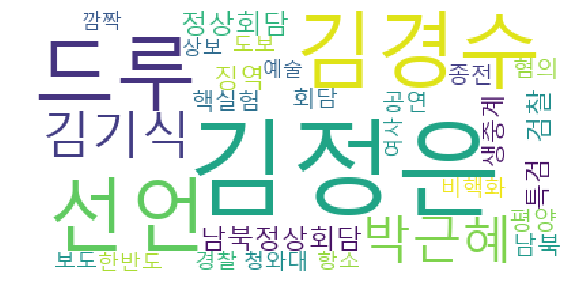

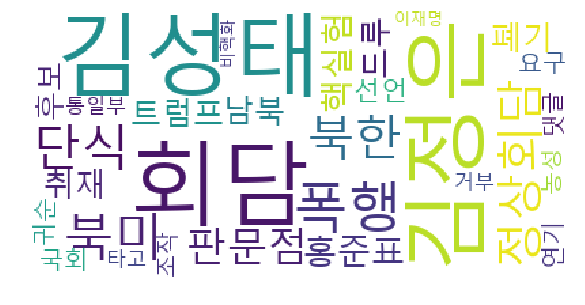

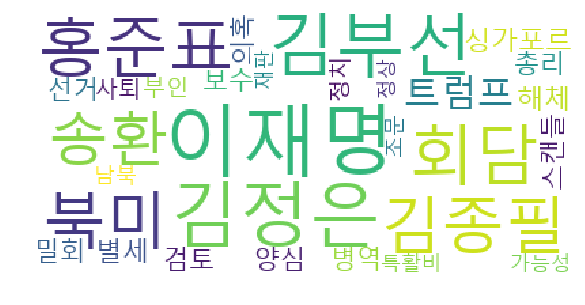

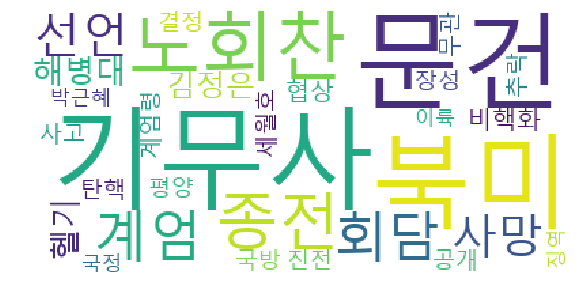

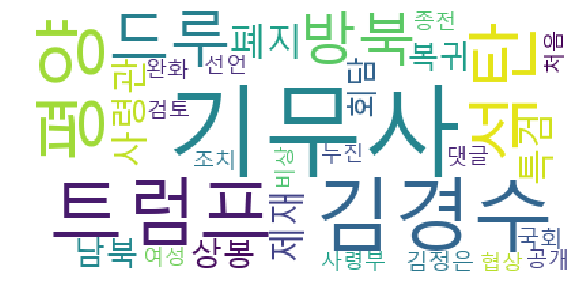

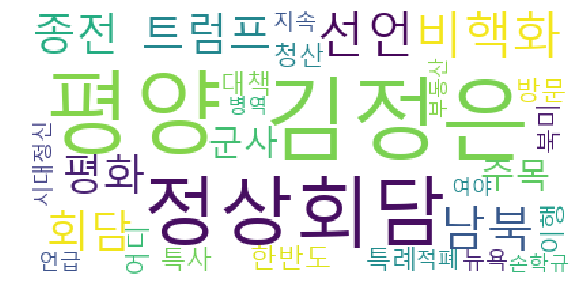

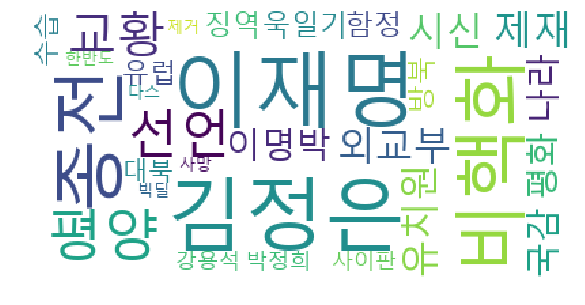

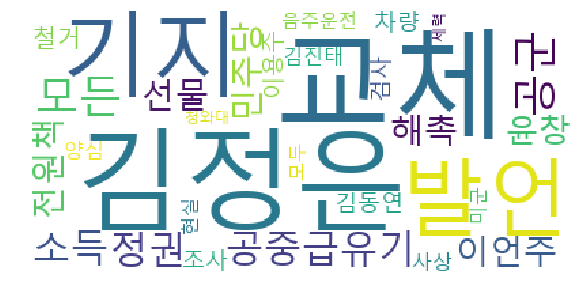

In [30]:
# 정치부분 1711~1811 <13개월> 워드클라우드

from wordcloud import WordCloud

dic = {}
for j in range(len(PoliticsWords5.T.iloc[:])): # 여기서 len은 26! 1711~1811의 13개월에 <단어, 빈도> 두 열이 있어서 13 X 2는 26개!
    if j % 2 == 0:# 각 월의 <단어> 열을 추출
        for i in range(len(EconomyWords5.iloc[:])): # 여기서 len은 30!!, 단어빈도수 top 30개!!
            
            dic[PoliticsWords5.T.iloc[j][i]] = int(PoliticsWords5.T.iloc[j+1][i] ** 1.2) # [j+1] 은 <빈도>!!
                                                                                    # 1.2 제곱은 비중을 높여서 글자 크게 보이게끔!
            
            
        wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                              background_color='white', relative_scaling =0.2).generate_from_frequencies(dic)


        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud)
        plt.axis('off')
        save_img = 'Politics_{}.png'.format(j)
        plt.savefig(save_img)  
        
        dic = {}
        
    else:
        pass

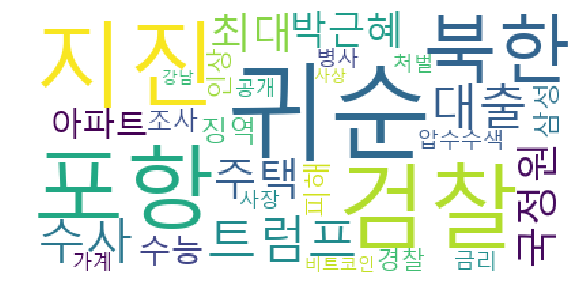

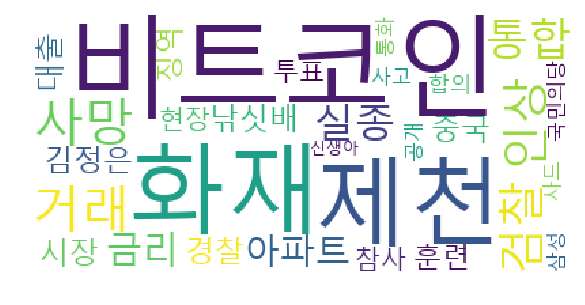

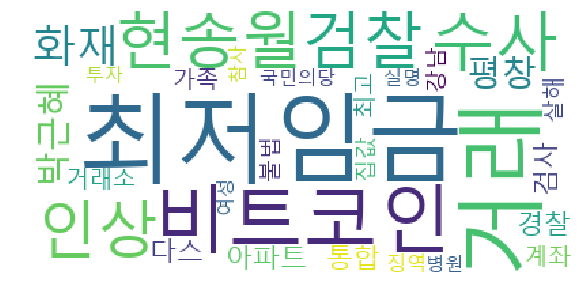

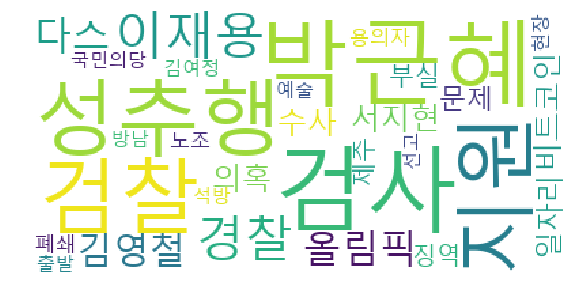

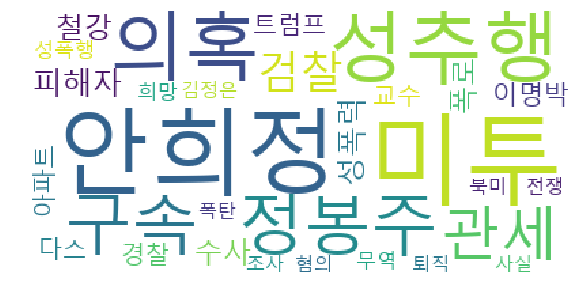

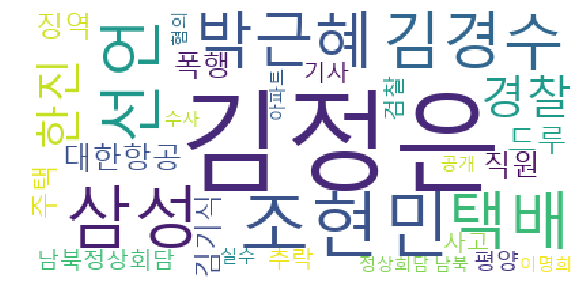

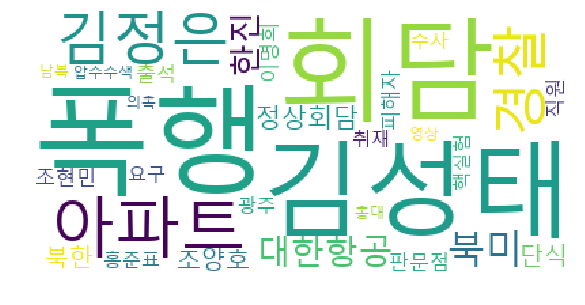

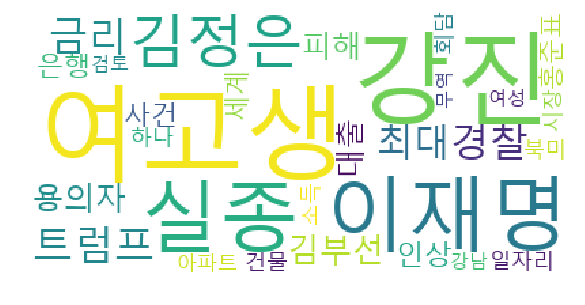

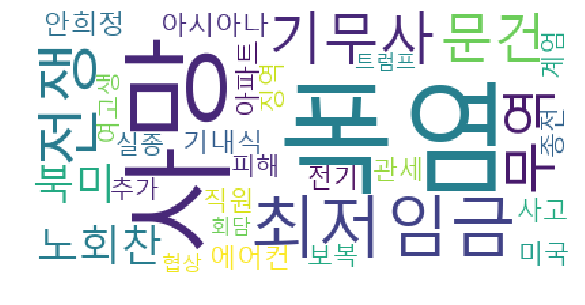

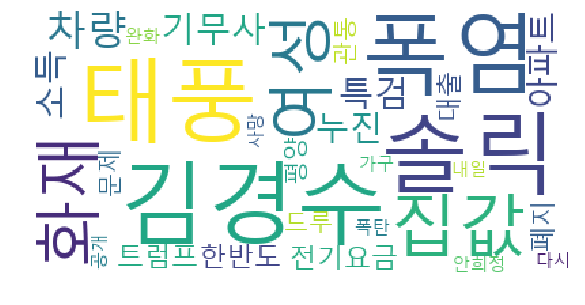

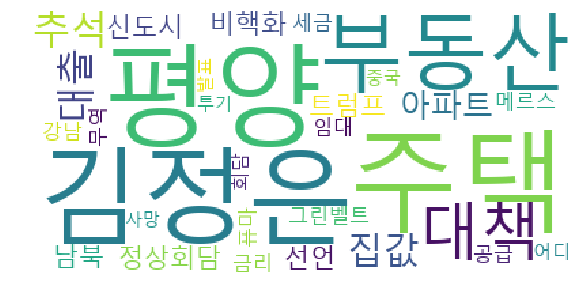

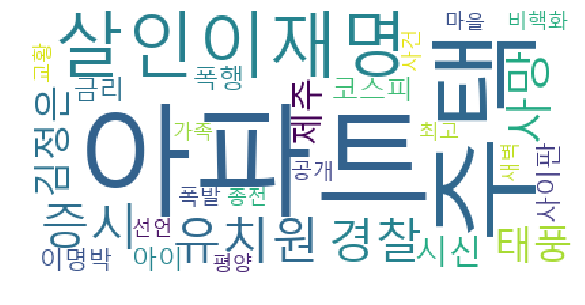

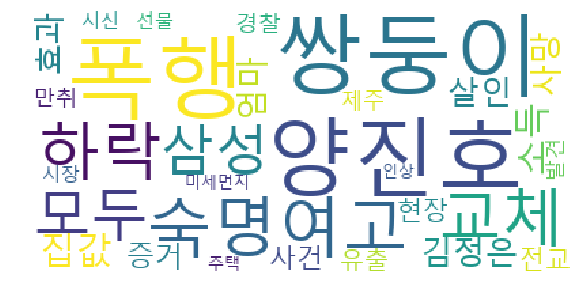

In [31]:
# total (정치,경제,사회) 전체 1711~1811 <13개월> 워드클라우드

dic = {}
for j in range(len(totalWords5.T.iloc[:])): # 여기서 len은 26! 1711~1811의 13개월에 <단어, 빈도> 두 열이 있어서 13 X 2는 26개!
    if j % 2 == 0:# 각 월의 <단어> 열을 추출
        for i in range(len(EconomyWords5.iloc[:])): # 여기서 len은 30!!, 단어빈도수 top 30개!!
            
            dic[totalWords5.T.iloc[j][i]] = int(totalWords5.T.iloc[j+1][i] ** 1.2) # [j+1] 은 <빈도>!!
                                                                                    # 1.2 제곱은 비중을 높여서 글자 크게 보이게끔!
            
            
        wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                              background_color='white', relative_scaling =0.2).generate_from_frequencies(dic)


        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud)
        plt.axis('off')
        save_img = 'total_{}.png'.format(j)
        plt.savefig(save_img)  
        
        dic = {}
        
    else:
        pass

In [115]:
for date, word in EconomyWords5.columns:
    
#     for 
    print(EconomyWords5[date][word])
#     print(EconomyWords5[date][word])


0       대출
1       주택
2       인상
3       최대
4       금리
5       삼성
6       가계
7     비트코인
8       강남
9      반도체
10      사상
11      조사
12     아파트
13      검찰
14    최저임금
15      지원
16      폭탄
17      경찰
18     롱패딩
19      징역
20      집값
21      상승
22      비리
23      승진
24      총수
25      사기
26      사장
27     부동산
28      지갑
29      일상
Name: 단어, dtype: object
0     11
1     10
2      9
3      8
4      8
5      7
6      7
7      7
8      6
9      5
10     5
11     5
12     5
13     4
14     4
15     4
16     4
17     4
18     4
19     3
20     3
21     3
22     3
23     3
24     3
25     3
26     3
27     3
28     3
29     3
Name: 빈도, dtype: int64
0     비트코인
1       거래
2       금리
3       인상
4       대출
5       시장
6       폭탄
7       통화
8       다시
9       삼성
10      세금
11      소득
12      계좌
13      연봉
14      해외
15      집값
16      대책
17      비리
18      급락
19      은행
20      가능
21     아파트
22      광풍
23    국민소득
24      물가
25      이슈
26      폭등
27      현금
28     보따리
29      규제
Name: 단어, dtype: object

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline

# 워드 클라우드 생성 함수
def generateWordCloud(data):
    # wordcloud에 단어 빈도를 전달한 dictionary 형 인자
    wordDic = {}
    
    for n in range(len(data.columns)):
        #
        if n % 2: